In [7]:
import PHDFitModel as phdmodel
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

import json

import time

In [8]:
#best_network_config = {'cnn_filters_hist': [16, 32, 128, 256, 1024],
#                       'cnn_filters_irf': [32, 128, 256, 512],
#                       'kernel_size_cnn': 20,
#                       'pool_size_cnn': 2,
#                       'padding_cnn': 1,
#                       'use_batchnorm_cnn': True,
#                       'fc_layer_sizes': [1024, 512, 256, 128, 32],
#                       'dropout_rate_fc': 0.0,
#                       'lr': 0.002,
#                       'step_size': 10,
#                       'gamma': 0.8,
#                       'batch_size': 64,
#                       'ua_weight': 300.0,
#                       'clip_grad': 1.0,
#                       'patience': 100}

#config_path = 'TrainedModels/optical_propierties_estimator_config.json'

#with open(config_path, 'w') as f:
#    json.dump(best_network_config, f, indent=4) 

In [9]:
model_path = "TrainedModels/rho30mm/optical_properties_estimator_weights_20250526173934.pth"
config_path = "TrainedModels/rho30mm/optical_propierties_estimator_config_20250526173934.json"

with open(config_path, 'r') as f:
    best_network_config = json.load(f)

print(best_network_config)

trained_model = phdmodel.OpticalPropertiesEstimator(best_network_config)


{'cnn_filters_hist': [16, 32, 256, 512, 2048], 'cnn_filters_irf': [16, 32, 128, 256, 1024], 'kernel_size_cnn': 30, 'pool_size_cnn': 2, 'padding_cnn': 2, 'use_batchnorm_cnn': True, 'fc_layer_sizes': [512, 256, 128, 32, 16], 'dropout_rate_fc': 0.2, 'use_rnn': False, 'rnn_hidden_dim': 64, 'rnn_layers': 2, 'rnn_bidirectional': False, 'rnn_dropout': 0.1, 'use_attention': False}


In [10]:
gpu_available = torch.cuda.is_available()
if gpu_available:
    trained_model.load_state_dict(torch.load(model_path))
else: 
    trained_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

device = torch.device("cuda" if gpu_available else "cpu")
trained_model.to(device)

OpticalPropertiesEstimator(
  (hist_cnn): Sequential(
    (0): Conv1d(1, 16, kernel_size=(30,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(30,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 256, kernel_size=(30,), stride=(1,), padding=(2,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(256, 512, kernel_size=(30,), stride=(1,), padding=(2,))
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
import os
sim_folder = "SIMs/rho30mm"

# Iterate through each file in the folder SIMs that starts with sim_results_

# First extract the suffix from the filename so they are loaded in the same order
sim_runs = []
for filename in os.listdir(sim_folder):
    if filename.startswith('sim_results_'):
        suffix = filename.split('_')[-1] # Extract the suffix
        sim_runs.append(suffix)

histograms_data = []
for suffix in sim_runs:
    filename = 'sim_results_' + suffix
    file_path = os.path.join(sim_folder, filename)
    histograms_data.append(np.load(file_path))

histograms_data = np.concatenate(histograms_data, axis=0) # Concatenate all histograms
histograms_data =  np.array(histograms_data, dtype=np.float32) # Convert to float32


irfs_data = []
for suffix in sim_runs:
    filename = 'sim_irfs_' + suffix
    file_path = os.path.join(sim_folder, filename)
    irfs_data.append(np.load(file_path))

irfs_data = np.concatenate(irfs_data, axis=0) # Concatenate all IRFs
irfs_data = np.array(irfs_data, dtype=np.float32) # Convert to float32


tags_data = []
for suffix in sim_runs:
    filename = 'sim_tags_' + suffix
    file_path = os.path.join(sim_folder, filename)
    tags_data.append(np.load(file_path))

tags_data = np.concatenate(tags_data, axis=0) # Concatenate all tags
tags_data = np.array(tags_data, dtype=np.float32) # Convert to float32


ua_data = tags_data[:, 0] # Extract ups
ups_data = tags_data[:, 1] # Extract ua

print(len(ua_data))
print(ua_data)
print(ups_data)

17000
[0.00666667 0.00666667 0.00666667 ... 0.0169697  0.00141414 0.00141414]
[1.14 1.14 1.14 ... 0.22 1.   1.  ]


In [12]:
## 2. Split data into training and validation sets
histograms_train, histograms_val, irfs_train, irfs_val, ups_train, ups_val, ua_train, ua_val = train_test_split(
    histograms_data, irfs_data, ups_data, ua_data, test_size=0.2, random_state=42
)

# 3. Create Datasets and DataLoaders
batch_size = 128

train_dataset = phdmodel.TurbidMediaDataset(histograms_train, irfs_train, ups_train, ua_train)
val_dataset = phdmodel.TurbidMediaDataset(histograms_val, irfs_val, ups_val, ua_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
#    Load a sample histogram and IRF (e.g., from your validation set or a new measurement)
sample_index = 5 # Example index from validation set
sample_histogram = torch.tensor(phdmodel.normalize_dtof(histograms_val[sample_index]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
sample_irf = torch.tensor(phdmodel.normalize_dtof(irfs_val[sample_index]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

tic = time.time()
trained_model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_optical_properties = trained_model(sample_histogram, sample_irf)
toc = time.time()

predicted_ups = predicted_optical_properties[0][0].item()
predicted_ua = predicted_optical_properties[0][1].item()
actual_ups = ups_val[sample_index]
actual_ua = ua_val[sample_index]

print(f"Predicted ups: {predicted_ups:.4f}, Actual ups: {actual_ups:.4f}")
print(f"Predicted ua: {predicted_ua:.4f}, Actual ua: {actual_ua:.4f}")
print("Inference time: {:.4f} seconds".format(toc - tic))

Predicted ups: 1.0412, Actual ups: 1.0306
Predicted ua: 0.0142, Actual ua: 0.0132
Inference time: 0.1651 seconds


/tmp/ipykernel_124179/898193421.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  error_ua.append(abs((actual_ua - predicted_ua)/actual_ua)*100)


Number of samples:  3400
Median error in ups:  3.4122343
Median error in ua:  5.1521826
Mean inference time per sample: 0.0025 seconds


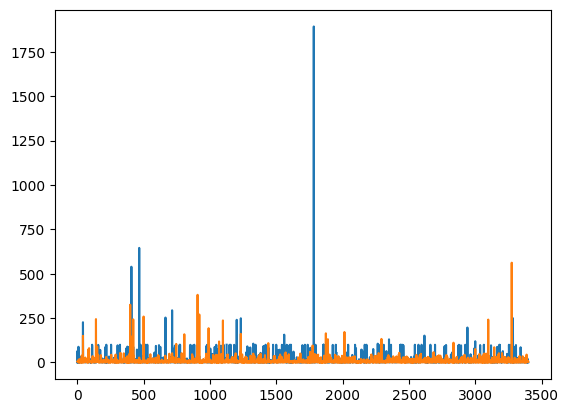

In [14]:
error_ua = []
error_ups = []
actual_uas = []
actual_upss = []

tic = time.time()

for i in range(len(histograms_val)):
    sample_histogram = torch.tensor(phdmodel.normalize_dtof(histograms_val[i]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
    sample_irf = torch.tensor(phdmodel.normalize_dtof(irfs_val[i]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension

    trained_model.eval() # Set model to evaluation mode
    with torch.no_grad():
        predicted_optical_properties = trained_model(sample_histogram, sample_irf)

    predicted_ups = predicted_optical_properties[0][0].item()
    predicted_ua = predicted_optical_properties[0][1].item()
    actual_ups = ups_val[i]
    actual_ua = ua_val[i]

    actual_uas.append(actual_ua)
    actual_upss.append(actual_ups)

    error_ua.append(abs((actual_ua - predicted_ua)/actual_ua)*100)
    error_ups.append(abs((actual_ups - predicted_ups)/actual_ups)*100)
    

toc = time.time()

print("Number of samples: ", len(histograms_val))
print("Median error in ups: ", np.nanmedian(error_ups))
print("Median error in ua: ", np.nanmedian(error_ua))
print("Mean inference time per sample: {:.4f} seconds".format((toc - tic)/len(histograms_val)))

plt.plot(error_ua, label='Error in ua')
plt.plot(error_ups, label='Error in ups')

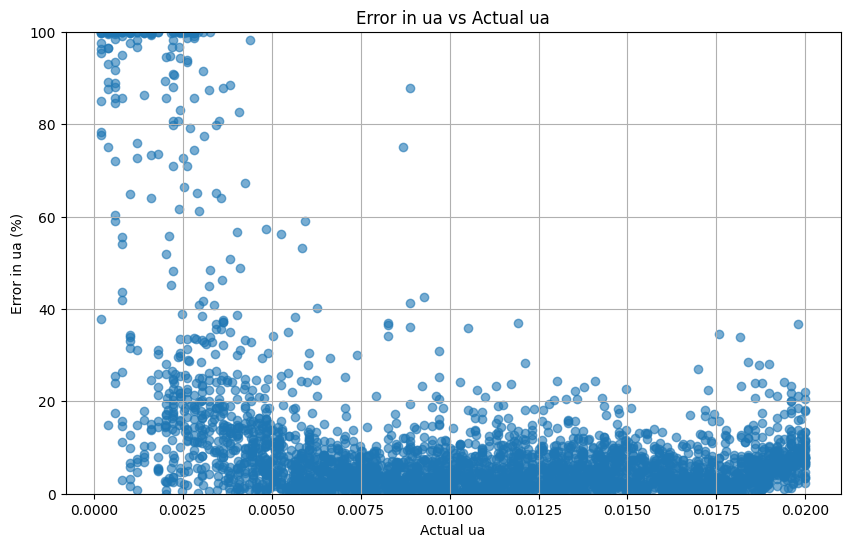

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_uas, error_ua, alpha=0.6)
plt.xlabel('Actual ua')
plt.ylabel('Error in ua (%)')
plt.ylim(0, 100)
plt.title('Error in ua vs Actual ua')
plt.grid(True)
plt.show()

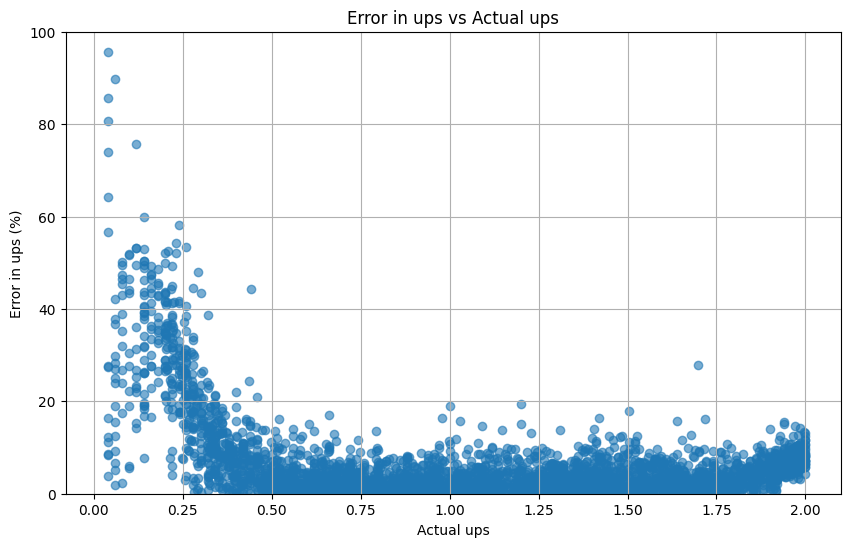

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_upss, error_ups, alpha=0.6)
plt.xlabel('Actual ups')
plt.ylabel('Error in ups (%)')
plt.ylim(0, 100)
plt.title('Error in ups vs Actual ups')
plt.grid(True)
plt.show()

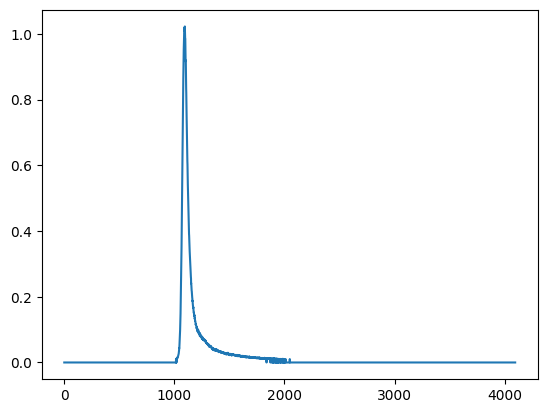

In [17]:
measurement_parent_folder = "/home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/"
IRF_suffix = "IRF/"
measurement_suffix = "leche"

irf = np.genfromtxt(measurement_parent_folder + IRF_suffix + "irf30mm_c01.asc", skip_footer=1, skip_header=10)
irf = phdmodel.normalize_dtof(irf)

plt.plot(irf)

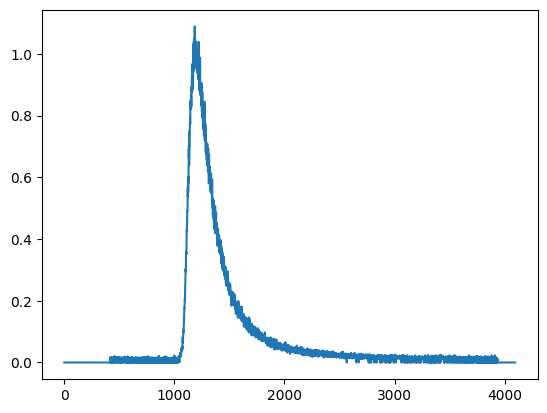

In [18]:
dtof_sample_150ml = np.genfromtxt(measurement_parent_folder + measurement_suffix + "=150ml/ref_homo_1750mlagua_150mlleche_185mltinta_30mm_c01.asc", skip_footer=1, skip_header=10)
dtof_sample_500ml = np.genfromtxt(measurement_parent_folder + measurement_suffix + "=500ml/ref_homo_1750mlagua_500mlleche_220mltinta_30mm_c01.asc", skip_footer=1, skip_header=10)

dtof_sample_150ml = phdmodel.normalize_dtof(dtof_sample_150ml)
dtof_sample_500ml = phdmodel.normalize_dtof(dtof_sample_500ml)

plt.plot(dtof_sample_500ml)

In [19]:
torch_dtof = torch.tensor(dtof_sample_500ml, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
torch_irf = torch.tensor(irf, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    predicted_optical_properties = trained_model(torch_dtof, torch_irf)

predicted_ups = predicted_optical_properties[0][0].item()
predicted_ua = predicted_optical_properties[0][1].item()

print(predicted_ua, predicted_ups)

0.0008965882007032633 0.6412792205810547


In [20]:
torch_dtof = torch.tensor(dtof_sample_150ml, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
torch_irf = torch.tensor(irf, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    predicted_optical_properties = trained_model(torch_dtof, torch_irf)

predicted_ups = predicted_optical_properties[0][0].item()
predicted_ua = predicted_optical_properties[0][1].item()

print(predicted_ua, predicted_ups)

0.0011440867092460394 0.19775712490081787


In [21]:
import os

milk_concentrations = []
uas = []
uas_sd = []
upss = []
upss_sd = []

for folder_name in os.listdir(measurement_parent_folder):
    if folder_name.startswith(measurement_suffix):
        folder_path = os.path.join(measurement_parent_folder, folder_name)
        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder_path}")
            folder_parts = folder_path.split('=')
            milk_concentration = int(folder_parts[1][:-2])
            milk_concentrations.append(milk_concentration)
            
            uas_folder = []
            upss_folder = []
            
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.asc'):
                    file_path = os.path.join(folder_path, file_name)
                    print(f"Processing file: {file_path}")
                    dtof = np.genfromtxt(file_path, skip_footer=1, skip_header=10)
                    #dtof = dtof/np.sum(dtof)
                    dtof = np.array(dtof, dtype=np.float32)
                    dtof = phdmodel.normalize_dtof(dtof)
                    
                    torch_dtof = torch.tensor(dtof, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimension
                    torch_irf = torch.tensor(irf, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        predicted_optical_properties = trained_model(torch_dtof, torch_irf)
                    predicted_ups = predicted_optical_properties[0][0].item()
                    predicted_ua = predicted_optical_properties[0][1].item()
                    uas_folder.append(predicted_ua)
                    upss_folder.append(predicted_ups)
                    print(predicted_ua, predicted_ups)
            
            uas.append(np.mean(uas_folder))
            uas_sd.append(np.std(uas_folder))
            upss.append(np.mean(upss_folder))
            upss_sd.append(np.std(upss_folder))                      
                    
                    

Processing folder: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=400ml
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=400ml/ref_homo_1750mlagua_400mlleche_210mltinta_30mm_c05.asc
0.0009735808125697076 0.5269230008125305
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=400ml/ref_homo_1750mlagua_400mlleche_210mltinta_30mm_c10.asc
0.001003500772640109 0.5389973521232605
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=400ml/ref_homo_1750mlagua_400mlleche_210mltinta_30mm_c08.asc
0.0009830112103372812 0.5440042018890381
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=400ml/ref_homo_1750mlagua_400mlleche_210mltinta_30mm_c01.asc
0.0009103218908421695 0.5167327523231506
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=400ml/ref_homo_1750mlagua_400mlleche_210mltinta_30mm_c06.asc
0.0009687420097179711 0.54

0.0009888694621622562 0.14191469550132751
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=100ml/ref_homo_1750mlagua_100mlleche_180mltinta_30mm_c03.asc
0.0009791121119633317 0.14132049679756165
Processing folder: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=50ml
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=50ml/ref_homo_1750mlagua_50mlleche_175mltinta_30mm_c10.asc
0.0008216073038056493 0.08946449309587479
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=50ml/ref_homo_1750mlagua_50mlleche_175mltinta_30mm_c04.asc
0.0008333281148225069 0.09116179496049881
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=50ml/ref_homo_1750mlagua_50mlleche_175mltinta_30mm_c02.asc
0.0008210867526941001 0.09043576568365097
Processing file: /home/nicocarbone/MedidasExperimentales/MedidasCamilo/rho30/leche=50ml/ref_homo_1750mlagua_50mlleche_175mltinta_3

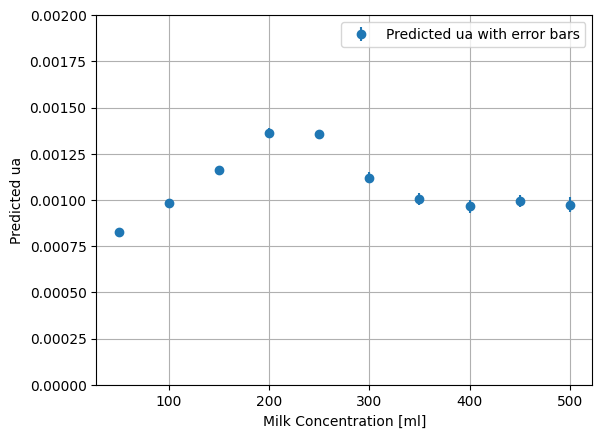

In [26]:
#plt.scatter(milk_concentrations, uas, label='Predicted ua')
plt.errorbar(milk_concentrations, uas, yerr=uas_sd, fmt='o', label='Predicted ua with error bars')
plt.xlabel('Milk Concentration [ml]')
plt.ylabel('Predicted ua')
plt.ylim(0, 0.002)
plt.legend()
plt.grid(True)
plt.show()

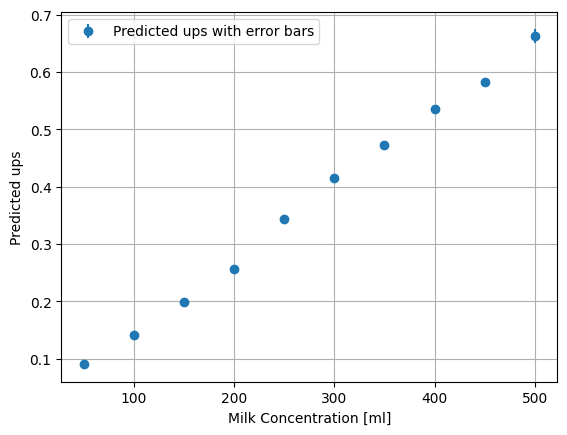

In [23]:
plt.errorbar(milk_concentrations, upss, yerr=upss_sd, fmt='o', label='Predicted ups with error bars')
plt.xlabel('Milk Concentration [ml]')
plt.ylabel('Predicted ups')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(upss)

[np.float64(0.6394742786884308), np.float64(0.3910403847694397), np.float64(0.6905375719070435), np.float64(0.5054169028997422), np.float64(0.3307474434375763), np.float64(0.7609489858150482), np.float64(0.5664602994918824), np.float64(0.26816959083080294), np.float64(0.2102416828274727), np.float64(0.45623313784599306)]
